# SHAP

![SHAP image sample](https://github.com/sony/nnabla-examples/raw/master/responsible_ai/shap/images/sample.png)
This example interactively demonstrates SHAP using nnabla's pre-trained model.

SHAP : A Unified Approach to Interpreting Model Predictions<br>
Scott Lundberg, Su-In Lee et. al., arXiv (2017) <br>
https://arxiv.org/abs/1705.07874

## Preparation
Let's start by installing nnabla and accessing [nnabla-examples repository](https://github.com/sony/nnabla-examples). 

In [1]:
!pip install nnabla-ext-cuda100
!git clone https://github.com/sony/nnabla-examples.git
%cd nnabla-examples/responsible_ai/shap

     |████████████████████████████████| 42.9 MB 63 kB/s 
     |████████████████████████████████| 18.3 MB 65 kB/s 
     |████████████████████████████████| 46 kB 4.7 MB/s 
     |████████████████████████████████| 131 kB 66.1 MB/s 
     |████████████████████████████████| 79 kB 9.4 MB/s 
     |████████████████████████████████| 7.7 MB 52.8 MB/s 
     |████████████████████████████████| 138 kB 73.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.6 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Cloning into 'nnabla-examples'...
remote: Enumerating obj

Import dependencies.

In [2]:
import os
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import nnabla as nn
from nnabla.utils.image_utils import imread
from nnabla.models.imagenet import VGG16
from utils import shap_computation

2021-07-20 11:57:46,359 [nnabla][INFO]: Initializing CPU extension...


## Image Preparation 
Prepare image to apply to SHAP.

In [3]:
url = 'https://upload.wikimedia.org/wikipedia/commons/4/4e/A_crab_spider_on_a_flower_preying_upon_a_euglossine_bee%2C_while_a_butterfly_looks_for_nectar.jpg'
target_img_path = 'input_flower_moth_spider.jpg'
if not os.path.isfile(target_img_path):
    tgt = urllib.request.urlopen(url).read()
    with open(target_img_path, mode='wb') as f:
        f.write(tgt)

Take a look at what the image looks like.  
We can see a flower in the middle on which a butterfly rests, which is called long-tailed skipper butterfly.

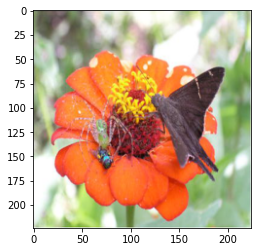

In [4]:
img = imread(target_img_path, size=(224, 224), channel_first=True)
plt.imshow(img.transpose(1,2,0))
plt.show()

Then we prepare images to use when computing shap.

In [5]:
file_path = "imagenet50"
if not os.path.isdir(file_path):
    !unzip "imagenet50.zip"
calc_images = []
for calc_img_path in os.listdir(file_path):
    calc_img = imread(file_path + "/" + calc_img_path, size=(224, 224), channel_first=True)
    calc_images.append(calc_img)
calc_images = np.array(calc_images)

Archive:  imagenet50.zip
   creating: imagenet50/
  inflating: imagenet50/sim_n03029197_6381.jpg  
  inflating: imagenet50/sim_n02010272_1613.jpg  
  inflating: imagenet50/sim_n03061345_7223.jpg  
  inflating: imagenet50/sim_n03523987_7290.jpg  
  inflating: imagenet50/sim_n01687978_7467.jpg  
  inflating: imagenet50/sim_n10374849_811.jpg  
  inflating: imagenet50/sim_n12560282_16028.jpg  
  inflating: imagenet50/sim_n09691729_2568.jpg  
  inflating: imagenet50/sim_n04404412_26251.jpg  
  inflating: imagenet50/sim_n07714571_3105.jpg  
  inflating: imagenet50/sim_n04583212_9954.jpg  
  inflating: imagenet50/sim_n02011805_6117.jpg  
  inflating: imagenet50/sim_n03518943_2240.jpg  
  inflating: imagenet50/sim_n09406793_39048.jpg  
  inflating: imagenet50/sim_n01887474_9375.jpg  
  inflating: imagenet50/sim_n02190166_6252.jpg  
  inflating: imagenet50/sim_n03235180_7802.jpg  
  inflating: imagenet50/sim_n02395694_14311.jpg  
  inflating: imagenet50/sim_n07560652_7278.jpg  
  inflating: ima

## Network Definition
Loading the model is very simple.<br>
You can choose other models such as `VGG11`, `VGG13`, by specifying the model's name as an argument. Of course, you can choose other pretrained models as well. See the [Docs](https://nnabla.readthedocs.io/en/latest/python/api/models/imagenet.html).

**NOTE**: If you use the `VGG16` for the first time, nnabla will automatically download the weights from `https://nnabla.org` and it may take up to a few minutes.

In [6]:
model = VGG16()

2021-07-20 11:57:48,119 [nnabla][INFO]: Downloading VGG-16.nnp from https://nnabla.org/pretrained-models/nnp_models/imagenet/VGG-16/VGG-16.nnp
VGG-16.nnp: 100%|██████████| 528M/528M [00:54<00:00, 10.2MB/s]


Loading /root/nnabla_data/nnp_models/imagenet/VGG-16.nnp.


In [7]:
batch_size = 1
x = nn.Variable((batch_size,) + model.input_shape)
# set training True since gradient of variable is necessary for SHAP
vgg = model(x, training=True, returns_net=True)
vgg_variables = vgg.variables

We now define the input, and extract the necessary outputs.  
pred: final output of the model

In [8]:
target_label_indices = {
    'butterfly': 326,# lycaenid, lycaenid butterfly
    'flower': 985,# daisy
    'spider': 74,# garden spider
}

input_name = list(vgg.inputs.keys())[0]
vgg_variables[input_name].d = img
pred = vgg_variables["VGG16/Affine_3"]
selected = pred[:, target_label_indices['butterfly']]

Let's see how the model predicted the image.  
We can see the model classified the image as we expect.  
Labels regarding butterfly comes high, while flower is also recognized although it is14th ranked probability.

In [9]:
selected.forward()

In [10]:
predicted_labels = np.argsort(-pred.d[0])
for i, predicted_label in enumerate(predicted_labels[:15]):
    print(f'Top {i+1}, Label index: {predicted_label},  Label name: {model.category_names[predicted_label]}')

Top 1, Label index: 326,  Label name: lycaenid, lycaenid butterfly
Top 2, Label index: 716,  Label name: picket fence, paling
Top 3, Label index: 321,  Label name: admiral
Top 4, Label index: 318,  Label name: lacewing, lacewing fly
Top 5, Label index: 323,  Label name: monarch, monarch butterfly, milkweed butterfly, Danaus plexippus
Top 6, Label index: 325,  Label name: sulphur butterfly, sulfur butterfly
Top 7, Label index: 953,  Label name: pineapple, ananas
Top 8, Label index: 985,  Label name: daisy
Top 9, Label index: 322,  Label name: ringlet, ringlet butterfly
Top 10, Label index: 94,  Label name: hummingbird
Top 11, Label index: 658,  Label name: mitten
Top 12, Label index: 304,  Label name: leaf beetle, chrysomelid
Top 13, Label index: 904,  Label name: window screen
Top 14, Label index: 738,  Label name: pot, flowerpot
Top 15, Label index: 309,  Label name: bee


## SHAP Computation

Now we compute SHAP for butterfly and then for flower to save the images.

In [11]:
shap_computation(
    model_graph=vgg,
    X=img,
    label=target_label_indices['butterfly'],
    output="img_butterfly.png",
    interim_layer_index=10,
    num_samples=50,
    dataset=calc_images,
    batch_size=25
)

2021-07-20 12:00:00,784 [nnabla][INFO]: Initializing CUDA extension...
2021-07-20 12:00:00,856 [nnabla][INFO]: Initializing cuDNN extension...


In [12]:
shap_computation(
    model_graph=vgg,
    X=img,
    label=target_label_indices['flower'],
    output="img_flower.png",
    interim_layer_index=10,
    num_samples=50,
    dataset=calc_images,
    batch_size=25
)

# Visualization

Finally, compare images in oneline to enable to see the differences clearly.

The **red** pixels represent places where SHAP judges **positive** influence to the prediction.<br>
On the other hand, **blue** pixel represents places where SHAP judges **negative** influence to the prediction.<br>

Image on the middle (pridiction for butterfly): The edge of the **butterfly** appears **red**, and the edge of the **flower** appears **blue**.<br>
Image on the right (pridiction for flower): The edge of the **butterfly** appears **blue**, and the edge of the **flower** appears **red**. 

In [13]:
img_butterfly = imread("img_butterfly.png", size=(224, 224),channel_first=True)
img_flower = imread("img_flower.png", size=(224, 224), channel_first=True)

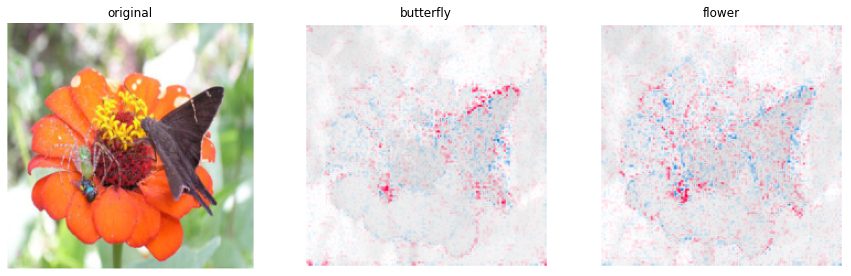

In [14]:
images = {
    'original': img.transpose(1,2,0),
    'butterfly': img_butterfly.transpose(1,2,0),
    'flower': img_flower.transpose(1,2,0),
}

row = 1
col = len(images)
fig, axes = plt.subplots(row, col, figsize=(15,15))

for i, (k, v) in enumerate(images.items()):
    axes[i].axis("off")
    axes[i].imshow(v)
    axes[i].set_title(k)